# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(os.path.join( os.getcwd(), '..', 'database.sqlite' )) 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# Sampling the data 
final = final.sample(n=100000, replace=True)

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:39<00:00, 2518.55it/s]


In [24]:
preprocessed_reviews[1500]

'little guy figured scratching post right away even though weeks old loves hiding inside though weeks not slip quite easily'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z]+', ' ', summary)
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    
    preprocessed_summary.append(summary.strip())


100%|██████████| 100000/100000 [00:26<00:00, 3714.51it/s]


In [27]:
final['CleanedText'] = preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText'] = final['CleanedText'].astype('str')

final['CleanedSummary'] = preprocessed_summary #adding a column of CleanedSummary which displays the data after pre-processing of the Summary 
final['CleanedSummary'] = final['CleanedSummary'].astype('str')

final['Text_Summary'] = final['CleanedSummary'] + final['CleanedText']

# # store final table into an SQlLite table for future.
# conn = sqlite3.connect('final.sqlite')
# c=conn.cursor()
# conn.text_factory = str
# final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
#              index=True, index_label=None, chunksize=None, dtype=None)
# conn.close()

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [29]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [30]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [31]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [32]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

In [33]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [35]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [36]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

In [37]:
# Source: https://docs.python.org/3/library/pickle.html

# Saving data to pickle file
def topicklefile(obj, file_name):
    pickle.dump(obj,open(file_name+'.pkl', 'wb'))

In [38]:
# Data from pickle file
def frompicklefile(file_name):
    data = pickle.load(open(file_name+'.pkl', 'rb'))
    return data

In [39]:
# Sort 'Time' column
final = final.sort_values(by='Time', ascending=True)

In [73]:
# Applying BOW on train and test data and creating the 
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

#Source: https://stackoverflow.com/questions/41298073/how-to-get-the-most-representative-features-in-the-following-tfidf-model
def apply_vectorizer(train_data):
    
    #Applying TF-IDF on Train data
    count_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10)

    #Applying BoW on Test data
    train_vect = count_vect.fit_transform(train_data)
    
    feature_names = np.array(count_vect.get_feature_names())
    
    idf_index = count_vect.idf_.argsort()
    
    feature_names = feature_names[idf_index]
    
    topicklefile(train_vect, 'train_vect')
    
    return count_vect, feature_names[:2000]

In [41]:
def build_co_occurance_matrix(top_features, X, window_size):
    coocur_matrix = np.zeros((len(top_features),len(top_features)))
    # Iterate over all the review+summary texts from the dataset 
    for x in tqdm(X):
        # Splitting the string into list of words
        text_corpus = x.split()
        # Initializing the pointers to zeroth col and row in the co occurance matrix for every review
        for index1 in range(len(top_features)):
            # Check in the word1 from the list is present in the corpus list of words
            if top_features[index1] in text_corpus:
                # Similar to word1, consider each word2 in the index range of index1
                # As the matrix is symmetric for a given review in X, we can simultaneously update the matrix on both the sides of the co-occurance matrix
                # The below loop will update the matrix on one side of the diagonal elements in the matrix
                for index2 in range(index1):
                    # Initialize occur_count to 0, Based on the presence of the word2 along with the presence of the word the count will be added
                    occur_count = 0
                    # Check if the word2 is not equal to word1 and word2 is in corpus list of words
                    if top_features[index2]!=top_features[index1] and top_features[index2] in text_corpus:
                        # Collect all the indices of all the occurances of word1 
                        word_index = [ind for ind,word in enumerate(text_corpus) if top_features[index1]==word]
                        # Get all the words in the word windows of word1
                        for index in word_index:
                            window_words=[]
                            if index+1<len(text_corpus):
                                window_words.extend(text_corpus[max(index-window_size,0): index] + text_corpus[index+1: index+window_size+1])
                            
                            elif index == len(text_corpus):
                                window_words.extend(text_corpus[index-window_size : index])
                                
                            # Count all the word2 occurances from the words obtained from the word window
                            occur_count += window_words.count(top_features[index2])
                        # Update the count in the symmetric cells of the co-occurence matrix at once
                        coocur_matrix[index2][index1] += occur_count
                        coocur_matrix[index1][index2] += occur_count
                    else:
                        # If the word2 is not present in the corpus list of words add zero to the respective symmetic cells in co-occurance matrix 
                        coocur_matrix[index2][index1] += 0
                        coocur_matrix[index1][index2] += 0
            else:
                # If the word1 is not present in the corpus list of words then add all the column for that word with 0
                coocur_matrix[index1][:] += 0
    return coocur_matrix

In [42]:
def apply_truncated_SVD(data, n_comp):
    t_svd = TruncatedSVD(n_components=n_comp)
    t_svd.fit(data)
    return t_svd, t_svd.explained_variance_ratio_

In [43]:
def optimal_truncated_SVD(data, n_comp):
    t_svd = TruncatedSVD(n_components=n_comp)
    t_svd.fit(data)
    X_new = t_svd.fit_transform(data)
    return X_new

In [44]:
#Source: https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
def select_n_components(var_ratio, goal_var):
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [45]:
#Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
def plot_cum_exp_var(t_svd):
    plt.plot(np.cumsum(t_svd.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [46]:
#Source: https://www.datasciencecentral.com/profiles/blogs/python-implementing-a-k-means-algorithm-with-sklearn
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
def apply_kmeans(data, clusters):
#   clusters = [i for in range(2,10,2)]
    inertias = []
    
    for cluster in clusters:
        kmeans = KMeans(n_clusters=cluster, n_jobs=-1)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    print('inertias: ',inertias)
    return inertias

In [47]:
def plot_scores_vs_clusters(clusters, inertias):
    plt.plot(clusters, inertias)
    plt.xlabel('n_clusters')
    plt.ylabel('Scores')
    plt.title('Elbow Plot')
    plt.show()

In [48]:
def retrain_kmeans(cluster, data):
    kmeans = KMeans(n_clusters=cluster, n_jobs=-1)
    kmeans.fit(data)
    labels = kmeans.labels_
    return labels

In [49]:
#https://andrew47.github.io/scikitlearn-cluster.html
from collections import Counter
def build_wordclouds(X, labels):
    review_labels = pd.DataFrame({'Top Features':X, 'labels':labels})
    
    for cluster in review_labels['labels'].unique():
        review_labels1 = review_labels[review_labels['labels']==cluster]
        
        if len(review_labels1) != 0:
            text = ' '.join(review_labels1['Top Features'])
            text = text.split()

            counts = Counter(text)
            counts = dict(counts)

            wordcloud = WordCloud(background_color = 'white')
            kMeansWordCloud = wordcloud.generate_from_frequencies(counts)
            plt.figure()
            plt.imshow(kMeansWordCloud)
            plt.axis("off")
    
    return review_labels

In [50]:
def sim_words_cosine_sim(input_word, X_new, review_labels):
    review_labels
    label = review_labels[review_labels['Top Features']==input_word]['labels'].values[0]
    
    review_labels1 = review_labels[review_labels['labels']==label]
    
    input_word_index = list(top_features).index(input_word)
    
    sim_words_in_cluster = list(review_labels1['Top Features'])
    
    sim_words_in_cluster_index=[]
    
    for word in sim_words_in_cluster:
        sim_words_in_cluster_index.append(list(top_features).index(word))
    
    cosine_similarities = []
    
    for index in sim_words_in_cluster_index:
        cos_sim = float(cosine_similarity(X_new[input_word_index].reshape(1, -1), X_new[index].reshape(1, -1)))
        cosine_similarities.append(cos_sim)
    
    features_cos_sim = pd.DataFrame({'Features':sim_words_in_cluster, 'Cosine Similarities':cosine_similarities})
    
    return features_cos_sim

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [51]:
# Please write all the code with proper documentation

In [74]:
X = np.array(final['Text_Summary'])
count_vect, top_features = apply_vectorizer(X)

In [75]:
train_vect = frompicklefile('train_vect')

### [5.2] Calulation of Co-occurrence matrix

In [76]:
# Please write all the code with proper documentation

In [77]:
coocur_matrix = build_co_occurance_matrix(list(top_features), X, 5)

100%|██████████| 100000/100000 [1:27:15<00:00, 19.10it/s] 


In [78]:
coocur_matrix

array([[0.0000e+00, 6.0330e+03, 1.6068e+04, ..., 7.2000e+01, 6.9000e+01,
        8.0000e+01],
       [6.0330e+03, 0.0000e+00, 2.3480e+03, ..., 1.0000e+01, 1.1000e+01,
        2.3000e+01],
       [1.6068e+04, 2.3480e+03, 0.0000e+00, ..., 1.3000e+01, 3.1000e+01,
        5.3000e+01],
       ...,
       [7.2000e+01, 1.0000e+01, 1.3000e+01, ..., 0.0000e+00, 2.0000e+00,
        1.0000e+00],
       [6.9000e+01, 1.1000e+01, 3.1000e+01, ..., 2.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.0000e+01, 2.3000e+01, 5.3000e+01, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00]])

### [5.3] Finding optimal value for number of components (n) to be retained.

In [79]:
# Please write all the code with proper documentation

In [80]:
t_svd, tsvd_exp_var_ratio_ = apply_truncated_SVD(coocur_matrix, len(top_features)-1)

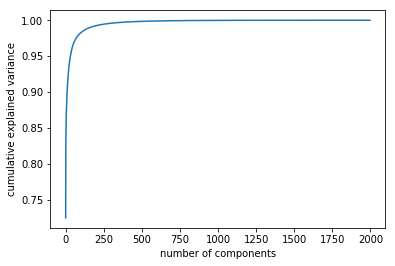

In [81]:
plot_cum_exp_var(t_svd)

In [82]:
n_comp= select_n_components(tsvd_exp_var_ratio_, 0.90)
print(n_comp)

11


In [83]:
X_new = optimal_truncated_SVD(coocur_matrix, n_comp)
X_new.shape

(2000, 11)

### [5.4] Applying k-means clustering

In [84]:
# Please write all the code with proper documentation

In [85]:
clusters = [i for i in range(2,10,2)]
inertias = apply_kmeans(X_new, clusters)

inertias:  [3947942773.255795, 1192518958.736823, 775065156.6024526, 705505792.8484215]


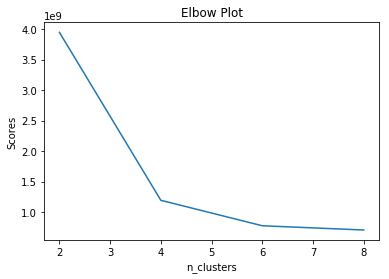

In [86]:
plot_scores_vs_clusters(clusters, inertias)

In [87]:
labels = retrain_kmeans(6, X_new)

### [5.5] Wordclouds of clusters obtained in the above section

In [88]:
# Please write all the code with proper documentation

<class 'numpy.ndarray'>


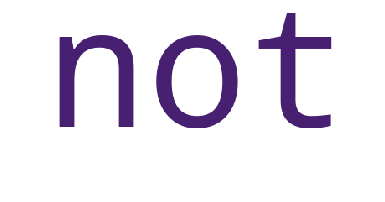

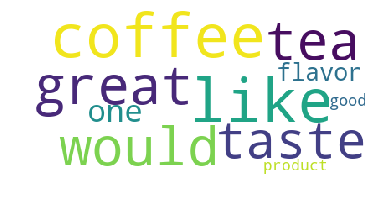

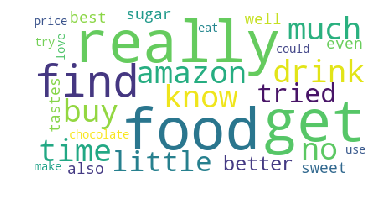

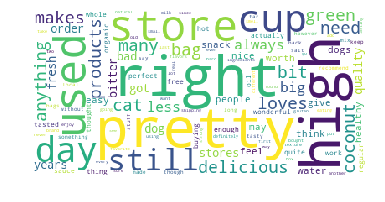

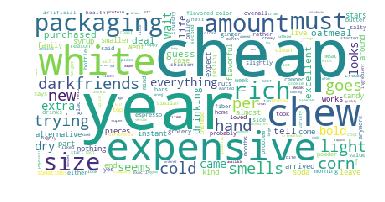

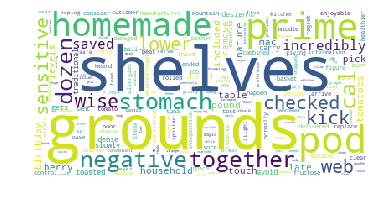

In [89]:
print(type(X_new))
review_labels = build_wordclouds(top_features, labels)

### [5.6] Function that returns most similar words for a given word.

In [90]:
# Please write all the code with proper documentation

In [92]:
features_cos_sim = sim_words_cosine_sim('food', X_new, review_labels)

In [93]:
features_cos_sim

,Cosine Similarities,Features
0,0.889184,love
1,0.909744,get
2,0.872552,no
3,0.810749,best
4,0.796198,amazon
5,0.879702,really
6,0.887681,much
7,0.895720,also
8,0.906809,time
9,0.895487,buy


# [6] Conclusions

In [94]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

## [6.1] Observations:

1. 2000 important features from TF-IDF vectorizer is obtained using _idf score.

2. Co-occurence matrix is built for 2000 important features.

3. '11' n_components is obtained when Truncated SVD is applied on the Co-occurence matrix U(n*n).

4. New matrix U' with n*k dimensions is obtained and K-menas clustering is applied on it.

5. The optimal number of clusters obtained is 6.

6. Building wordclouds for all the clusters.

7) Each wordcloud represents the following:
        a) WC1: only 'not'
        b) WC2: This cluster contains about coffee, tea and their attributes like taste, flavour.
        c) WC3: This cluster contains words like food, drink, sugar, sweet,tastes, better and etc.
        d) WC4: This clusters contains words like pretty, right, store, cup and also about food products and their attributes like delicious, taste, bitter and etc.
        e) WC5: This cluster contains words related to buying products on Amazon.
        f) WC6: This cluster contains words related to home and homemade products